<a href="https://colab.research.google.com/github/akaver/NLP2019/blob/master/Assignment_3_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Assignment 3

In this assignment, you have to improve a "wakeword spotting" model. Grading is done on the accuracy of the model on a blind test set.

## Background

Virtual assistants (such as Amazon Alexa and Google Home) are always-on devices that can be controlled via speech. Usually they use a so-called wake word to understand that the next speech utterance is indended to them, e.g. "Hey Alexa, what's the wheather like?". Therefore, it is very important that they are really good at recognizing when the wake word was said.

The data that we use comes from a semi-open-source virtal assistant called Snips (https://snips.ai/). It consists of a corpus of speech utterances, where in about 10% of the utterances a user says "Hey Snips", the rest of the utterances contain other kind of speech, noise or silence. The data is recorded in noisy and reverberant conditions.

The data loading and baseline model has been provided. The baseline model is a multi-layer convolutional NN with global max pooling. 

Training data, development data and a blind test set is provided.

## Task

Your task is to improve the baseline model using any means that we have covered in the course. Some ideas:


* Try an improved model, such as a recurrent NN, or a convolutional model combined with recurrent layers
* Try improved training, e.g. use label smoothing, mixup, learning rate scheduling
* Since the data is provided as features, you cannot really do data augmentation, but you could try augmentation in the spectral domain, e.g. create new copies of training examples by stretching and squeezing features, or masking them (a la SpecAugment)
* When using convolutional models, try k-max pooling, or even some form of attention
* Residual blocks
* You can even train multiple models and combine them.

In the end, you have to use your trained model to provide predictions (in the form of probabilities) for the blind test set, for which currently all labels are set to zero.
I will use the predictions to compute the actual accuracy (**in terms of F1 score**) on the test set of your model.


Grading:


*   1-15 points depending on score of your model on the test set.

Explanation: the submitted predictions will get points that is proportional to the relative improvement of your score, compared to the baseline model and the best model. More formally, if F_baseline is the baseline F1, F_x your F1 score and F_max the score by the best submission, then your points will be calculated as:

p = max(0, 15.0 * (F_x - F_baseline) / (F_best - F_baseline))

Example: let's say that the baseline model results in F1=89 on the test set. Let's say that the best submission achives 93, and your model achives 92. Then, your score is equal to:



In [0]:
15.0 * (92-89) / (93-89)

11.25

Note that dev set and test set are quite similar, so a high score on dev set should also result in a high score on test set. Still, it's not a guarantee that a high score on dev set equals a good performance on the test set. To avoid overfitting the model architecture and hyperparameters, sometimes researchers divide the dev set randomly to two, and check that improvments are consistent on both sets. You may use this approach as well.

## Update

Due to wide protests, the grading scheme is slightly changed:

*   The baseline model score will be computed from 5 trained models, and the worst score is selected as the baseline (i.e. I will train 5 baseline models and use the worst one as the baseline)
*   The maximum score F_best will be determined based on the 3rd ranked submission. Of course, the maximum points is still capped at 15 points.


Next, we will go through data loading and buidling the model. I recommend to use a GPU-enabled Colab session to do this task:

In [0]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Let's download the data.

In [0]:
! rm -f snips_subset_data.zip
! wget https://phon.ioc.ee/~tanela/tmp/snips_subset_data.zip

--2019-05-02 10:38:09--  https://phon.ioc.ee/~tanela/tmp/snips_subset_data.zip
Resolving phon.ioc.ee (phon.ioc.ee)... 193.40.251.126
Connecting to phon.ioc.ee (phon.ioc.ee)|193.40.251.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 384475583 (367M) [application/zip]
Saving to: ‘snips_subset_data.zip’

snips_subset_data.z 100%[===================>] 366.66M  8.93MB/s    in 84s     

2019-05-02 10:39:34 (4.38 MB/s) - ‘snips_subset_data.zip’ saved [384475583/384475583]



In [0]:
! unzip -o snips_subset_data.zip

Archive:  snips_subset_data.zip
  inflating: train.pkl               
  inflating: dev.pkl                 
  inflating: test_blind.pkl          
  inflating: sample_0.wav            
  inflating: sample_1.wav            


There are train development and blind test sets, and two sample files. Let's play the sample files. In the first one, the user says "Hey Snips":

In [0]:
import IPython.display as ipd
ipd.Audio('sample_1.wav')

The other sample contains no wake word:

In [0]:
ipd.Audio('sample_0.wav')

Let's load the data, using Python's pickle module:

In [0]:
import pickle

In [0]:
train_data = pickle.load(open("train.pkl", "rb"))
dev_data = pickle.load(open("dev.pkl", "rb"))
test_data = pickle.load(open("test_blind.pkl", "rb"))


All sets contain 10000 utterances:

In [0]:
len(train_data), len(dev_data), len(test_data)

(10000, 10000, 10000)

One data example is a tuple that has the following members: ID (a string), label (0 if not wake word, 1 if wake word) and a numpy array of MFCC features. That is, in order to save space and time, I have already converted the wav files to 13-dimensional MFCC coeficcients:

In [0]:
train_data[0]

('rev1_000928a2-a966-424e-9f2b-eb75cf32fc2e',
 0,
 array([[ 50.302788 , -20.490438 ,  -3.4453092, ..., -19.347622 ,
         -13.798249 , -21.41375  ],
        [ 54.49878  , -24.169605 ,  -6.4716535, ...,  -2.2359266,
         -14.204623 , -13.378721 ],
        [ 56.04467  , -17.779474 ,  -0.9864044, ..., -21.541626 ,
         -11.630922 ,  -6.467897 ],
        ...,
        [ 56.486355 , -23.782326 ,  -0.9864044, ...,   3.5402765,
          -2.4197826,  -8.069376 ],
        [ 55.161304 , -26.49329  ,  -7.039093 , ...,   2.0962262,
          -3.5034466,  -1.7778502],
        [ 55.60299  , -22.814123 ,  -1.932137 , ...,  -3.679978 ,
          -0.3879137,  -1.4346762]], dtype=float32))

Now, lets implement the data loading and batching mechanism. Since the utterances are of different length, we use torchtext's BucketIterator, so that utterances of similar length are grouped into one batch. But since we are not dealing with text but audio, we have to use some tricks so that torchtext's BucketIterator will work properly. You probably don't have to change this part.

In [0]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.data import BucketIterator, RawField


In [0]:
# this is used when a list of data items is transformed into a batch
def features_batch_process(batch):
  return torch.nn.utils.rnn.pad_sequence(batch, batch_first=True).to(device), torch.tensor([len(item) for item in batch])

# this is used when a list of data items is transformed into a batch
def labels_batch_process(batch):
  return torch.tensor(batch).to(device)

ID = RawField()
FEATURES = RawField(postprocessing=features_batch_process)
LABEL = RawField(postprocessing=labels_batch_process)
setattr(ID, "is_target", False)
setattr(FEATURES, "is_target", False)
setattr(LABEL, "is_target", True)

from collections import namedtuple
# each item iis represented as a named tuple with three fields
Utterance = namedtuple('Utterance', 'id features labels')

class AudioDataset(Dataset):
  def __init__(self, data_list):
    self.data_list = data_list
    self.fields = {"id": ID, "features" : FEATURES, "labels" : LABEL}
    
  def __len__(self):
    return len(self.data_list)
  
  def __getitem__(self, idx):
    return Utterance(self.data_list[idx][0], torch.tensor(self.data_list[idx][2]), self.data_list[idx][1])


In [0]:
train_dataset = AudioDataset(train_data)
dev_dataset = AudioDataset(dev_data)
test_dataset = AudioDataset(test_data)


In [0]:
from torchtext.data import BucketIterator, Field

In [0]:
train_iter = BucketIterator(train_dataset, batch_size=32, sort_key=lambda x: len(x.features), sort=False, shuffle=True, sort_within_batch=True)
dev_iter = BucketIterator(dev_dataset, batch_size=32, sort_key=lambda x: len(x.features), sort=False, shuffle=True, sort_within_batch=True)
test_iter = BucketIterator(test_dataset, batch_size=32, sort_key=lambda x: len(x.features), sort=False, shuffle=True, sort_within_batch=True)

In [0]:
batch = next(iter(train_iter))


In [0]:
batch


[torchtext.data.batch.Batch of size 32]
	[.id]:['rev1_e5724b8a-a426-4722-be94-d9d22fe6600e', 'rev1_ee648894-398e-4e4b-8088-0dd329c97b79', 'rev1_9a17e746-28fd-4426-bb4d-9a6057c388f0', 'rev1_e022a8c0-f2a1-4baf-8788-eabb98fade77', 'rev1_0a9b9d4f-b87c-4ff3-ab73-361bd29e6f94', 'rev1_8f15ec4d-261c-434d-be59-568f95e3639f', 'rev1_26448532-cffd-46e5-bdfd-45f8d4fae7e5', 'rev1_184c019b-8f54-4841-963a-68771a87805f', 'rev1_c7341bb0-109a-45fb-9937-e1536c549ae8', 'rev1_cbfd984d-261c-4180-a954-04feb9ffd4d5', 'rev1_ab155602-c6da-450c-9fd1-dfe21b6309d5', 'rev1_82644751-96ba-47ea-a5e3-5f7e7f6e0a7a', 'rev1_b53c93dc-3904-4f2b-a37c-ce268a32c274', 'rev1_0d84d2ee-f067-47af-bb4a-eed2fce4f7eb', 'rev1_5511b92e-9e53-4b1c-af94-cb49ec832bf9', 'rev1_fc7139e0-e223-44e5-b1f0-9ccf20edfb3a', 'rev1_3302b45c-122a-4a18-8ef5-75b3b649a337', 'rev1_1517abee-e8d3-4577-a93b-8dfae1184b1c', 'rev1_5651ee38-23ef-414c-a1b5-75ca6bb2877e', 'rev1_14a37836-9571-4ab8-a7ee-63015d7624b5', 'rev1_10f647aa-547c-490e-bfa8-1fd996c67799', 'rev1_

As seen from above, each batch has the following fields: id, features and labels. The field 'id' is just a list of file IDs (we need it when producing predictions for the blind test set). The field 'features' is a tuple of two items: a batch_size \* max_len \* 13 tensor of features, and a tensor contaiing the actual lengths of the utterances in the batch. Finally, the field 'labels' lists the 0/1 label values.

Let's explore it more carefully. First, let's display the features for the 1st item in the batch:

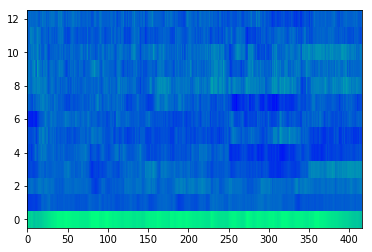

In [0]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
plt.imshow(batch.features[0][0].cpu().numpy().T, origin="lower", aspect='auto', cmap=cm.winter)


Next, let's display the utterance length. As you see, the items in the batch have similar lengths:

In [0]:
batch.features[1]

tensor([416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416,
        416, 416, 416, 416, 416, 416, 416, 416, 416, 412, 412, 412, 412, 412,
        412, 412, 412, 412])

And finally, the labels (it's possible that they are all 0 since there much more non-wakeword samples):

In [0]:
batch.labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

Now, the baseline model:

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import sys

In [0]:
class KeywordCnn(nn.Module):
  
  def __init__(self, num_classes, feature_dim, dropout_prob=0.2):
    super(KeywordCnn, self).__init__()
    self.input_bn = nn.BatchNorm1d(feature_dim)
    self.conv1 = nn.Conv1d(feature_dim, 32, kernel_size=5, stride=1)
    self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1)
    self.conv3 = nn.Conv1d(64, 64, kernel_size=3, stride=1)
    self.conv4 = nn.Conv1d(64, 64, kernel_size=3, stride=1)
    
    
    self.dropout = nn.Dropout(dropout_prob)
    self.fc = nn.Linear(64, num_classes)
    
  def forward(self, x, lengths):
    # Conv1d takes in (batch, channels, seq_len), but raw signal is (batch, seq_len, channels)
    x = x.permute(0, 2, 1).contiguous()
    x = self.input_bn(x)
    x = F.relu(self.conv1(x))
    x = F.max_pool1d(x, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool1d(x, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool1d(x, 2)
    
    x = F.relu(self.conv4(x))
    # Global max pooling
    x = F.max_pool1d(x, x.size(2))
    x = x.view(-1, 64)
    x = self.dropout(x) 
    logit = self.fc(x)
    return logit

Now, the training and evaluation routine:

In [0]:
import sklearn.metrics

def train(model, num_epochs, train_iter, dev_iter, device, log_interval=10):

  optimizer = torch.optim.Adam(model.parameters())

  steps = 0
  best_acc = 0
  last_step = 0
  
  for epoch in range(1, num_epochs+1):
    print("Epoch %d" % epoch)
    for batch in train_iter:
      # set training mode
      model.train()
      features, target = batch.features, batch.labels
     

      optimizer.zero_grad()
      logit = model(features[0], features[1])

      loss = F.cross_entropy(logit, target)
      loss.backward()
      optimizer.step()

      steps += 1

    train_acc = evaluate("train", train_iter, model)                
    dev_acc = evaluate("dev", dev_iter, model)                

def evaluate(name, data_iter, model):
  # set evaluation mode (turns off dropout)
  model.eval()
  corrects, avg_loss = 0, 0
  y_true = torch.tensor([]).long()
  y_pred = torch.tensor([]).long()
  for batch in data_iter:
    features, target = batch.features, batch.labels

    logit = model(features[0], features[1])
    loss = F.cross_entropy(logit, target, reduction='sum')

    avg_loss += loss.item()
    batch_predictions = torch.max(logit, 1)[1].view(target.size()).data
    
    corrects += (batch_predictions == target.data).sum()
    
    y_pred = torch.cat((y_pred, batch_predictions.detach().cpu()))
    y_true = torch.cat((y_true, target.detach().cpu()))

  size = len(data_iter.dataset)
  avg_loss /= size
  accuracy = 100.0 * float(corrects)/size
  
  f1 = sklearn.metrics.f1_score(y_true, y_pred)
  
  print('  Evaluation on {} - loss: {:.6f}  acc: {:.4f}%({}/{}), f1: {:4f}'.format(
      name,
      avg_loss, 
      accuracy, 
      corrects, 
      size,
      f1))
  return accuracy, avg_loss

Let's train the baseline model:

In [0]:
model = KeywordCnn(3, 13).to(device)
train(model, 10, train_iter, dev_iter, device=device)

Epoch 1


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  Evaluation on train - loss: 0.234020  acc: 88.6100%(8861/10000), f1: 0.000000
  Evaluation on dev - loss: 0.222691  acc: 89.0400%(8904/10000), f1: 0.000000
Epoch 2
  Evaluation on train - loss: 0.149152  acc: 94.2300%(9423/10000), f1: 0.712219
  Evaluation on dev - loss: 0.144099  acc: 94.5500%(9455/10000), f1: 0.722646
Epoch 3
  Evaluation on train - loss: 0.127257  acc: 95.2200%(9522/10000), f1: 0.766829
  Evaluation on dev - loss: 0.126901  acc: 95.2100%(9521/10000), f1: 0.756729
Epoch 4
  Evaluation on train - loss: 0.085954  acc: 97.0000%(9700/10000), f1: 0.859155
  Evaluation on dev - loss: 0.088207  acc: 96.7500%(9675/10000), f1: 0.842003
Epoch 5
  Evaluation on train - loss: 0.064625  acc: 97.8500%(9785/10000), f1: 0.907686
  Evaluation on dev - loss: 0.069158  acc: 97.4700%(9747/10000), f1: 0.887705
Epoch 6
  Evaluation on train - loss: 0.054869  acc: 98.1600%(9816/10000), f1: 0.922428
  Evaluation on dev - loss: 0.063527  acc: 97.4700%(9747/10000), f1: 0.890995
Epoch 7
  Ev

Finally, we make predictions (in terms of probablities) on the blind test set.

In [0]:
def make_test_predictions(model):
  with open("test_predictions.txt", "w") as f:
    for batch in test_iter:
      file_ids, features, target = batch.id, batch.features, batch.labels
      logit = model(features[0], features[1])
      probs = F.softmax(logit, dim=1)
      for i in range(len(batch)):
        print(file_ids[i], probs[i, 0].item(), probs[i, 1].item(), file=f)

In [0]:
make_test_predictions(model)

In [0]:
!head test_predictions.txt

rev1_14af1a10-dcd2-4920-ba8c-421dc32615a0 0.9968305230140686 0.0031694932840764523
rev1_d2f743ac-e4b6-4157-97e0-9997f322d65e 1.0 8.261386241770197e-09
rev1_7fb43096-fd87-47fd-bd3e-1e4c16191977 0.9999545812606812 4.539535439107567e-05
rev1_ff177c48-9331-4c12-8503-747b2a8acc26 1.0 1.995627829654012e-10
rev1_9d143b34-a0d2-41bc-a866-476b00757784 0.9999997615814209 2.2624713835739385e-07
rev1_2287a7b1-46f0-4488-95e3-e18c58a44c34 1.0 8.479969504371354e-11
rev1_35efda47-42de-4c04-8bae-049635a89074 1.0 8.371481285962545e-10
rev1_c0e24d85-63a5-4c3a-bed3-1eed84d0a329 0.9999947547912598 5.2767045417567715e-06
rev1_ce2ebe72-b0ca-4fd9-b9a2-551bd842307b 1.0 1.937072897282061e-16
rev1_367f0225-86be-4231-bbf9-f4036ed36bc3 0.9999990463256836 9.754608072398696e-07


## Submission

When you have finished tuning the model, you should generate predictions on the blind test set, using the model. Then you should download the generated file "test_predictions.txt" and submit it via Moodle (as an attachment). To download the file from Colab, open the Colab built in file explorer (press the ">" arrow in the top-left corner and select the "Files" tab to reveal the file explorer).

NB! In the addition to the file submissions, you also have to describe what you did and what you model architecture is, and what tricks you tried that led to improvement, and also what you tried but didn't help. Failure to provide such description will reduce your points!

Please also give a link to the Colab notebook (generate it using the Share button in the top-right corner). If you don't use Colab, submit the source code via plain text, but *please* use properly formatted code blocks.